In [1]:
import math
import pypot.dynamixel
from pypot.dynamixel.conversion import dxl_code
from pypot.dynamixel.conversion import dxl_decode
from time import sleep, time

from lib import Motor
import control_tables
from utils import read_from_file, dxl_decode_value

import matplotlib
import matplotlib.pyplot as plt
from utils import write_in_file
import numpy as np

In [2]:
DXL_ID = 20
PORT = "/dev/ttyUSB0"
INPUT_TENSION = 12.78

configs = {
    "MX-106": {"resistance": 2.0, "torque_constant": 2.3593725498111775},
    "MX-64": {"resistance": 3.6, "torque_constant": 8.011176076962043},
}


In [3]:
# Setup shoulder
dxl_io = pypot.dynamixel.Dxl320IO(PORT)
motor = Motor(dxl_io, DXL_ID, control_tables.MX_106, configs['MX-106']['resistance'], configs['MX-106']['torque_constant'], INPUT_TENSION)

motor.torque_enabled = False
motor.mode = 16 # PWM Control mode
motor.torque_enabled = True
motor.motor_tension = 0

In [4]:
times = []
positions = []
motor_tension = []
motor_torques = []
angular_velocities = []
back_emfs = []

for pwm_unit in range(-500, 500):
    motor.motor_tension = pwm_unit / 100

    sleep(.1)

    times.append(time())
    positions.append(motor.position)
    motor_tension.append(motor.motor_tension)
    motor_torques.append(motor.torque)
    angular_velocities.append(motor.velocity)
    back_emfs.append(motor.back_emf)


write_in_file(times, "times.txt")
write_in_file(positions, "positions.txt")
write_in_file(motor_tension, "motor_tension.txt")
write_in_file(motor_torques, "motor_torques.txt")
write_in_file(angular_velocities, "angular_velocities.txt")
write_in_file(back_emfs, "back_emfs.txt")

motor.motor_tension = 0
motor.torque_enabled = False

Les values ont été écrites dans le fichier times.txt avec succès.
Les values ont été écrites dans le fichier positions.txt avec succès.
Les values ont été écrites dans le fichier motor_tension.txt avec succès.
Les values ont été écrites dans le fichier motor_torques.txt avec succès.
Les values ont été écrites dans le fichier angular_velocities.txt avec succès.
Les values ont été écrites dans le fichier back_emfs.txt avec succès.


In [5]:
times = np.array(read_from_file("times.txt"))
positions = np.array(read_from_file("positions.txt"))
motor_tension = np.array(read_from_file("motor_tension.txt"))
motor_torques = np.array(read_from_file("motor_torques.txt"))
angular_velocities = np.array(read_from_file("angular_velocities.txt"))
back_emfs = np.array(read_from_file("back_emfs.txt"))

Static friction: 1.6778126704970466


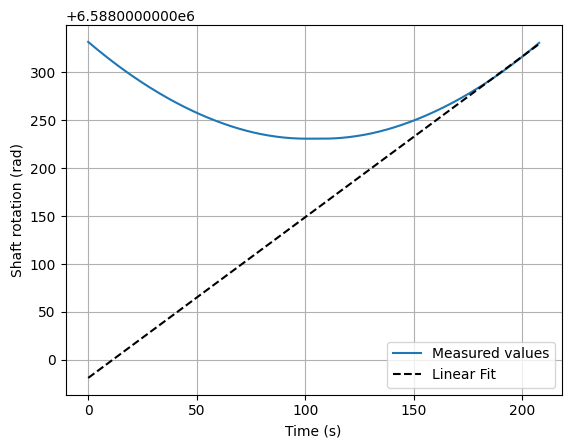

In [12]:
first_time = times[0]
times_scaled = np.array(list(map(lambda x: x - first_time, times)))
positions_rad = np.array(list(map(lambda x: math.radians(x), positions)))

plt.figure()
plt.grid()
plt.plot(times_scaled, positions_rad, label="Measured values")

# Resample
lower_bound = 180
index = -1
for i, value in enumerate(times_scaled):
    if value >= lower_bound:
        index = i
        break

# Remap times
slope, intersect = np.polyfit(times_scaled[index:], positions_rad[index:], 1)
poly1d_fn = np.poly1d((slope, intersect))

print(f"Static friction: {slope}")
plt.plot(times_scaled, poly1d_fn(times_scaled), '--k', label="Linear Fit")

plt.xlabel("Time (s)")
plt.ylabel("Shaft rotation (rad)")
plt.legend()

plt.show()

## Calcul du moment d'intertie du solide

$J_\Delta = \int_V r^2 dm$

$r$ étant la distance de chaque point du solide à l'axe $\Delta$

$J_\Delta = \rho le \left[ \frac{x^3}{3} \right]^l_0 = \rho le \frac{L^3}{3} = \frac{mL^2}{3}$

In [13]:
# Inertial moment of the bar: \frac{mL^2}{3}
mass = 0.08 # Kg
length = 0.5 # m
inertial_moment = (mass * pow(length, 2)) / 3

print(f"Inertial moment: {inertial_moment} Kg.m^2")

Inertial moment: 0.006666666666666667 Kg.m^2


$T_m(t) - T_f = J \frac{d\omega(t)}{dt}$ \
$T_f = T_m(t) - J \frac{d\omega(t)}{dt}$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Coefficients: [-0.12127746 -0.56061302 -0.47001329 -0.26110969 -0.13974794  0.59132029
 -0.4856983   0.27422605]


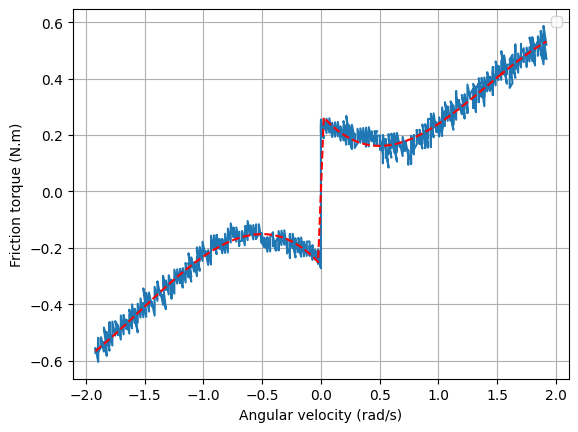

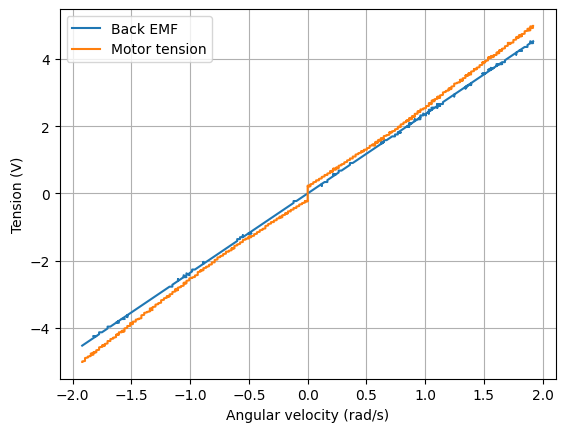

In [95]:
from scipy.optimize import curve_fit

def get_velocity_derivative(values, dt=1):
    derivative_values = []

    for i in range(len(values) - 1):
        dy = values[i + 1] - values[i]
        dx = dt
        derivative_values.append(dy / dx)

    return derivative_values

velocities_converted = list(map(lambda x: x * (np.pi / 30), angular_velocities)) # To rad.s^{-1}
velocities_derivatives = get_velocity_derivative(velocities_converted)
friction_torques = [motor_torques[t] - inertial_moment * velocities_derivatives[t] for t in range(len(velocities_derivatives))]

plt.figure()
plt.plot(velocities_converted[:len(friction_torques)], friction_torques)

def signum(x):
    return np.sign(x)

def friction(x, a, b, c, d, e, f, g, h):
    return np.where(x < 0, a * x ** 3 + b * x ** 2 + c * x + d, np.where(x > 0, e * x ** 3 + f * x ** 2 + g * x + h, 0))

# Use curve_fit to get the coefficients
popt, pcov = curve_fit(friction, velocities_converted[:len(friction_torques)], friction_torques)
print(f"Coefficients: {popt}")


# Plot the fitted curve
plt.plot(velocities_converted, [friction(x, *popt) for x in velocities_converted], '--r')

plt.grid()
plt.xlabel("Angular velocity (rad/s)")
plt.ylabel("Friction torque (N.m)")
plt.legend()

plt.show()

plt.figure()
plt.plot(velocities_converted, back_emfs, label="Back EMF")
plt.plot(velocities_converted, motor_tension, label="Motor tension")

plt.grid()
plt.xlabel("Angular velocity (rad/s)")
plt.ylabel("Tension (V)")
plt.legend()

plt.show()